# Download the spectra for each source

In [10]:
%matplotlib inline
import sys, os, glob, copy, re

from astropy.io import fits, ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table
from astropy.convolution import Box1DKernel, convolve
from astroquery.sdss import SDSS

import scienceplots

plt.style.use(['bright', 'science', 'no-latex','notebook'])

read files

In [11]:
data_agn_updated = ascii.read('hsc_agn_updated.txt')
data_agn_compare = ascii.read('hsc_agn_compare.txt')
data_agn = ascii.read('hsc_agn.txt')

prepare a table for downloading flag (?) 

In [14]:
data_agn_download = copy.deepcopy(data_agn_updated)

plot the table in a skymap

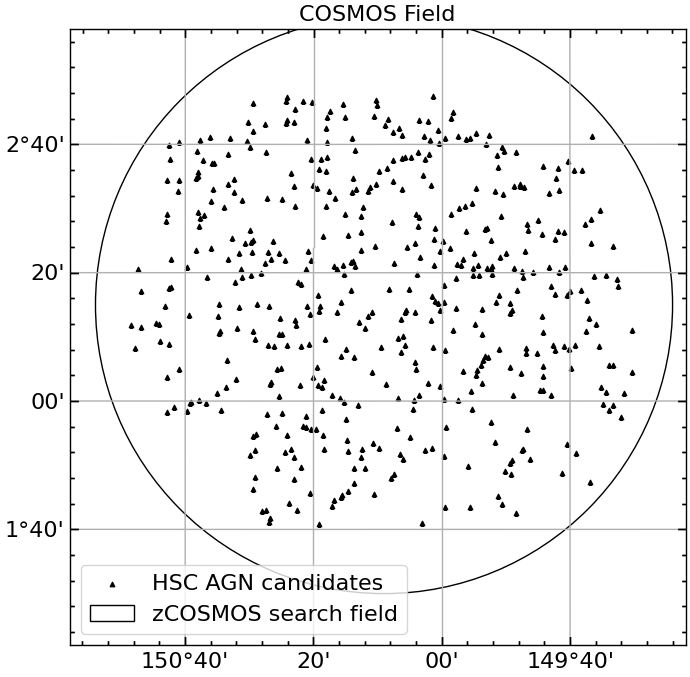

In [16]:
import ligo.skymap.plot

ra, dec = data_agn_updated['RAdeg'], data_agn_updated['DEdeg']
data_coords = SkyCoord(ra, dec, unit=[u.deg, u.deg])

fig = plt.figure(figsize=[12, 8], dpi=100)
ax1 = plt.axes(projection='astro degrees zoom', center='150d10m 2d10m', radius='0.8 deg')

ax1.scatter(ra, dec, transform=ax1.get_transform('world'), s=10, marker='^', color='k', alpha=1, label='HSC AGN candidates')

circle = plt.Circle((150.15, 2.25), 0.75, fill=False, transform=ax1.get_transform('world'), label='zCOSMOS search field')
ax1.add_artist(circle)

ax1.grid()
ax1.coords['ra'].set_auto_axislabel(False)
ax1.coords['dec'].set_auto_axislabel(False)
ax1.legend(frameon=True)
ax1.set_title('COSMOS Field')

plt.show()

### Dataset overview

The following sources have a publically available spectra

* Magellean/zCOSMOS
* DEIMOS
* SDSS

The following sources need more inspection: 

* HSC PDR3: it consists of many sources that may or may not be available


## Magellan

inquiry website: https://irsa.ipac.caltech.edu/data/COSMOS/

We first download all the spectra and match it into our catalog. 

Put `150.15 2.25` into `Coordinates/Object`, `2` into `Image Search Size (deg)` (whatever but `2` runs the fastest), `0.75 deg` into `Source Search Radius`, check `Images must cover coordinate`and uncheck `Match with image search size`, and submit, and then download `magellan_opt_spec_30.tbl`. It contains all the coordinates and links of the spectra we may want to use. 

Then, we match it into our catalog. 

In [18]:
magellean_targets = ascii.read('spec/magellan_opt_spec_30.tbl')
# prettify
pattern = re.compile(r'.*href="(.*)" target.*')
for i in range(len(magellean_targets)): 
    for key in ['TBL', 'FITS', 'SPEC_Preview_JPG']: 
        magellean_targets[key][i] = pattern.findall(magellean_targets[key][i])[0]

magellean_coords = SkyCoord(magellean_targets['ra'], magellean_targets['dec'], unit=[u.deg, u.deg])
idx_magellean, idx_data, d2d, _ = data_coords.search_around_sky(magellean_coords, 0.5*u.arcsec)

len(idx_magellean), len(np.unique(idx_data))

(205, 204)

Fill in the downloading table. 

In [19]:
data_agn_download['flag_magellan'] = False
data_agn_download['z_magellan'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['flag_magellan'][idx_data[i]] = True
    data_agn_download['z_magellan'][idx_data[i]] = magellean_targets['redshift'][idx_magellean][i]

Download the data. The whole precess takes ~2 mins. 

Naming convention: `magellean_<ID>.fits` (ID not index)

In [20]:
magellean_dir = 'spec/Magellan'
magellean_id = data_agn_download[idx_data]['ID']
magellean_links = magellean_targets[idx_magellean]['FITS']

for i in range(len(magellean_id)): 
    os.system('wget '+magellean_links[i]+' -O '+os.path.join(magellean_dir, 'magellan_'+str(magellean_id[i])+'.fits'))

# manually clear output after downloading

Note: 

* Magellan has 205/1240 targets matched, which is less than zCOSMOS has 236/20098 matches. 
* ID=153 has multiple returns, checked below and sample spectra section 
  * The two matches have the same spectra link, which supports z=0.695

### zCOSMOS

SKIP THIS PART because zCOSMOS is overlapped with Magellen (contains unfixed probs)

In [22]:
zcosmos_targets = ascii.read('spec/zcosmosdr3.tbl')
# prettify
pattern = re.compile(r'.*href="(.*)" target.*')
for i in range(len(zcosmos_targets)): 
    for key in ['Spectrum_FITS', 'Spectrum_TBL', 'Spectrum_Preview', 'HST_stamp_jpg', 'HST_stamp_fits']: 
        zcosmos_targets[key][i] = pattern.findall(zcosmos_targets[key][i])[0]

zcosmos_coords = SkyCoord(zcosmos_targets['ra'], zcosmos_targets['dec'], unit=[u.deg, u.deg])
idx_zcosmos, idx_data, d2d, _ = data_coords.search_around_sky(zcosmos_coords, 0.5*u.arcsec)

len(idx_zcosmos), len(np.unique(idx_data))

(236, 236)

Fill the flag in the downloading table. 

In [23]:
data_agn_download['flag_zcosmos'] = False

for i in range(len(data_agn_download)): 
    if i in idx_data: 
        data_agn_download['flag_zcosmos'][i] = True

Download the data. The whole precess takes ~3 mins. UNCOMMENT IF YOU NEED TO DOWNLOAD AGAIN. 

Naming convention: `zcosmos_<ID>.fits` (ID not index)

In [797]:
# zcosmos_dir = 'spec/zCOSMOS'
# zcosmos_id = data_agn_download[idx_data]['ID']
# zcosmos_links = zcosmos_targets[idx_zcosmos]['Spectrum_FITS']

# for i in range(len(zcosmos_id)): 
#     os.system('wget '+zcosmos_links[i]+' -O '+os.path.join(zcosmos_dir, 'zcosmos_'+str(zcosmos_id[i])+'.fits'))


Compare one of the inconsistent sources to the template AGN spectrum

template spectra: https://classic.sdss.org/dr5/algorithms/spectemplates/

HDU description: https://classic.sdss.org/dr5/dm/flatFiles/spSpec.html 

## DEIMOS

The data retrieval is as same as zCOSMOS, but download `deimos_redshift_linksIRSA.tbl`. 

**DEIMOS table contains possible spec-z value.**

In [25]:
deimos_targets = ascii.read('spec/deimos_redshift_linksIRSA.tbl')
# prettify
deimos_targets = deimos_targets[deimos_targets['fits1d']!='null']
pattern = re.compile(r'.*href="(.*)">.*')
for i in range(len(deimos_targets)): 
    for key in ['fits1d']: #, 'ascii1d', 'jpg1d', 'fits2d']: 
        # print(i, key)
        deimos_targets[key][i] = 'https://irsa.ipac.caltech.edu' + pattern.findall(deimos_targets[key][i])[0]

deimos_coords = SkyCoord(deimos_targets['ra'], deimos_targets['dec'], unit=[u.deg, u.deg])
idx_deimos, idx_data, d2d, _ = data_coords.search_around_sky(deimos_coords, 0.5*u.arcsec)

len(idx_deimos), len(np.unique(idx_data))

(118, 118)

Update the downloading flag table 

In [26]:
data_agn_download['flag_deimos'] = False
data_agn_download['z_deimos'] = -1.

for i in range(len(idx_data)): 
    data_agn_download['flag_deimos'][idx_data[i]] = True
    if deimos_targets['zspec'][idx_deimos[i]] not in ['0', 'NA']: 
        data_agn_download['z_deimos'][idx_data[i]] = deimos_targets['zspec'][idx_deimos][i]

Download the data. The whole precess takes ~2 mins. 
Naming convention: `deimos_<ID>.fits` (ID not index)

In [27]:
deimos_dir = 'spec/DEIMOS'
deimos_id = data_agn_download[idx_data]['ID']
deimos_links = deimos_targets[idx_deimos]['fits1d']

for i in range(len(deimos_id)): 
    print(i)
    os.system('wget '+deimos_links[i]+' -q -O '+os.path.join(deimos_dir, 'deimos_'+str(deimos_id[i])+'.fits'))

# manually clear output after downloading

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


### Sample spectra

1.373


FLUX                                                                             [astropy.io.fits.card]
IVAR                                                                             [astropy.io.fits.card]


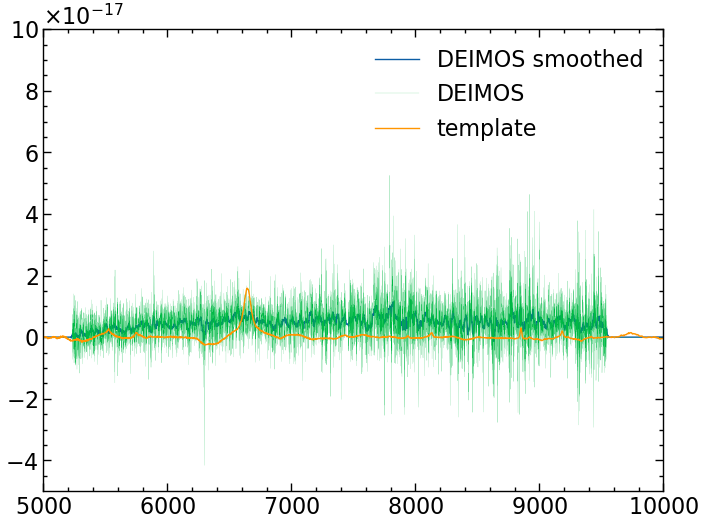

In [28]:
hdu3 = fits.open('spec/DEIMOS/deimos_59.fits')
data3 = hdu3[1].data
box1d_kernel = Box1DKernel(width=30)
flux = convolve(data3['FLUX'][0]*1e-19, box1d_kernel)
plt.plot(data3['LAMBDA'][0], flux, label='DEIMOS smoothed', linewidth=1)
plt.plot(data3['LAMBDA'][0], data3['FLUX'][0]*1e-19, label='DEIMOS', linewidth=0.1)

# template
z = data_agn_updated['z'][58]
print(z)
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
plt.plot(np.logspace(start, stop, num)*(1+z), datatemp[1]*1e-17, label='template', linewidth=1)

plt.xlim(5000, 10000)
plt.ylim(-0.5e-16, 1e-16)
plt.legend();

# deimos_targets[idx_deimos][np.where(data_agn_download[idx_data]['ID']==59)]['jpg1d']

## HSC

data release: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data-access__pdr3/

inquiry website: https://hsc-release.mtk.nao.ac.jp/datasearch/

keyword description: https://hsc-release.mtk.nao.ac.jp/schema/#pdr3.pdr3_dud_rev.specz 

source description: https://hsc-release.mtk.nao.ac.jp/doc/index.php/catalog-of-spectroscopic-redshifts__pdr3/

### Grab the HSC data and see what database it comes from

Then, we match our catalog to csv that contains its source. 

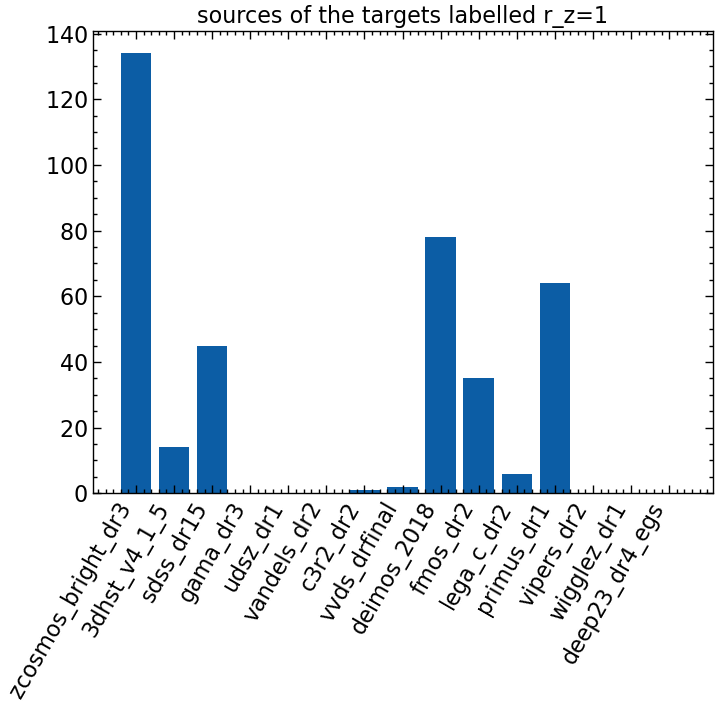

In [29]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

source_keys = ['specz_flag_zcosmos_bright_dr3', 'specz_flag_3dhst_v4_1_5', 'specz_flag_sdss_dr15', 'specz_flag_gama_dr3', 'specz_flag_udsz_dr1', 'specz_flag_vandels_dr2', 'specz_flag_c3r2_dr2', 'specz_flag_vvds_drfinal', 'specz_flag_deimos_2018', 'specz_flag_fmos_dr2', 'specz_flag_lega_c_dr2', 'specz_flag_primus_dr1', 'specz_flag_vipers_dr2', 'specz_flag_wigglez_dr1', 'specz_flag_deep23_dr4_egs']
hsc_targets = ascii.read('spec/420753.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])
hsc_duplication_mask = hsc_targets['specz_duplicationflag']==10

idx_hsc_pdr3, idx_hsc_specz, d2d, _ = data_coords[data_hsc_mask].search_around_sky(hsc_coords, 0.5*u.arcsec)

hsc_sources = {}
for key in source_keys: 
    hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][key])

plt.bar([key[11:] for key in hsc_sources.keys()], hsc_sources.values())
plt.xticks(rotation=60, ha='right');
plt.title('sources of the targets labelled r_z=1');

TODO: check all the sources in HSC and download them

```
specz_flag_zcosmos_bright_dr3
specz_flag_3dhst_v4_1_5
specz_flag_sdss_dr15 
specz_flag_deimos_2018
specz_flag_fmos_dr2
specz_flag_primus_dr1
```


### Solve the inconsistent redshifts

Now, we can check which catalog the inconsistent data comes from. 

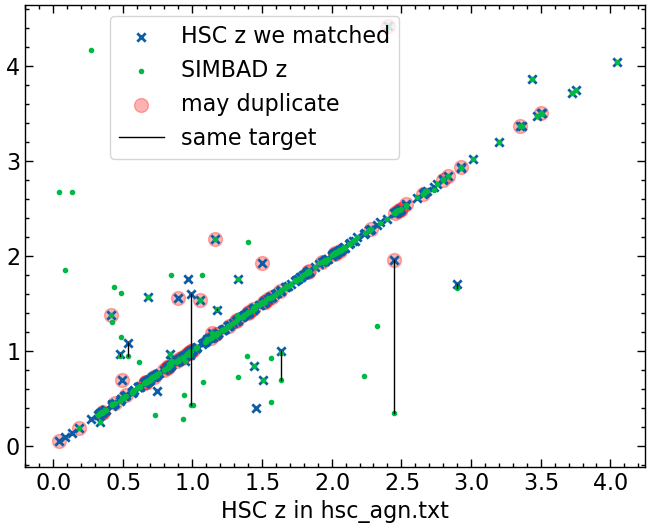

In [30]:
compare_mask = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']!=0
duplication_mask = hsc_targets[idx_hsc_pdr3]['specz_duplicationflag']!=100
match_mask = d2d<1*u.arcsec

plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & compare_mask], 
            hsc_targets[idx_hsc_pdr3]['specz_redshift'][match_mask & compare_mask], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & compare_mask], 
            data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'][match_mask & compare_mask], 
            marker='.', label='SIMBAD z')

# duplication flag
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][match_mask & duplication_mask & compare_mask], 
            hsc_targets[idx_hsc_pdr3]['specz_redshift'][match_mask & duplication_mask & compare_mask], 
            marker='o', label='may duplicate', alpha=0.3, zorder=0, c='r', s=100)

# check if we actually have 3 different values
x = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']
y1 = hsc_targets[idx_hsc_pdr3]['specz_redshift']
y2 = data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z']
for i in range(len(idx_hsc_pdr3)): 
    if abs(x[i]-y1[i])>0.1 and abs(x[i]-y2[i])>0.1:
        plt.plot([x[i], x[i]], [y1[i], y2[i]], color='k', linewidth=1)
plt.plot(0, 0, color='k', linewidth=1, label='same target')

plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

1. Overlapping `.` and `x` but not in $y=x$ indicates that HSC z actually gives the same result as SIMBAD, which means that the HSC-z in `hsc_agn.txt` gives a wrong result than DR3. 

2. Single `.` means that HSC is indeed different from SIMBAD, and maybe `HSC` is wrong. We need to further examine where these dots fome from. 

3. Single `x` means that the data we matched and the data in `hsc_agn.txt` are different, but `hsc_agn.txt` gives the same result as SIMBAD. 

4. There are a few objects that has 3 values in 3 catalogs, all of which are duplicated sources. 

Ignore 0 values. These are the sources have no SIMBAD spectrum in good quality. 

"May duplicate" means that there is object(s) in HSC database within 0.5 arcsec. 

One possible reason for those off `x` (1. and 3.) is that they used L1 norm instead of cone search to match the catalog. 

#### For case 2, we check which database the inconsistent values come from. 

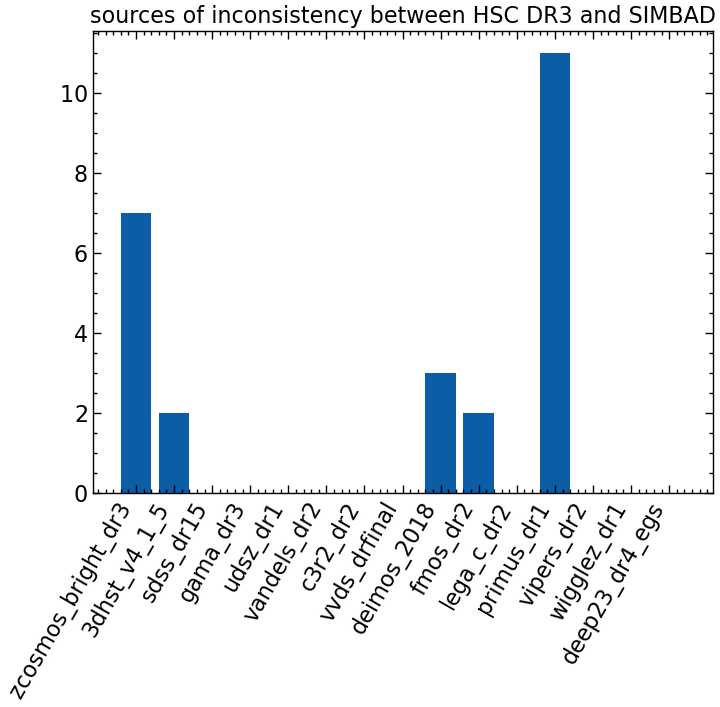

In [31]:
check_hsc_mask = (abs(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'] - hsc_targets[idx_hsc_pdr3]['specz_redshift'])<0.05) & \
                 (abs(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'] - data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'])>0.05)

check_hsc_sources = {}
for key in source_keys: 
    check_hsc_sources[key] = np.count_nonzero(hsc_targets[idx_hsc_pdr3][check_hsc_mask][key])

plt.bar([key[11:] for key in check_hsc_sources.keys()], check_hsc_sources.values())
plt.xticks(rotation=60, ha='right');
plt.title('sources of inconsistency between HSC DR3 and SIMBAD');

Plot the distribution of the bar chart above

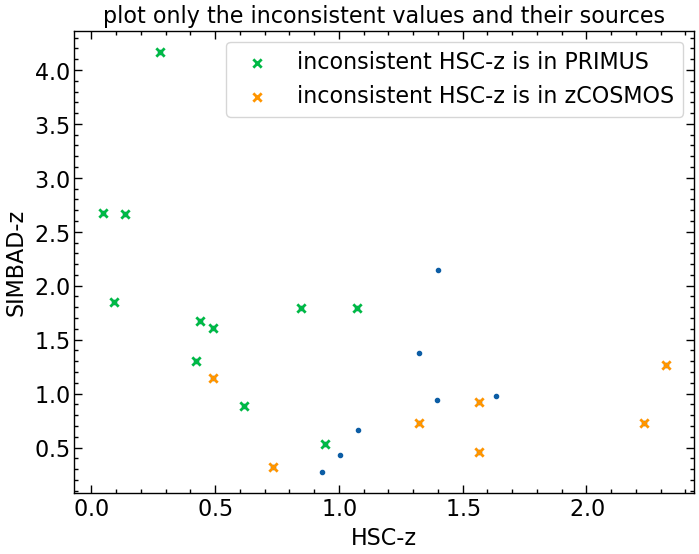

In [32]:
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'], 
        marker='.')
mask_primus = hsc_targets[idx_hsc_pdr3][check_hsc_mask]['specz_flag_primus_dr1']==True
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'][mask_primus], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'][mask_primus], 
        marker='x', label='inconsistent HSC-z is in PRIMUS')
mask_zcosmos = hsc_targets[idx_hsc_pdr3][check_hsc_mask]['specz_flag_zcosmos_bright_dr3']
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['HSC-z'][mask_zcosmos], 
        data_agn_compare[data_hsc_mask][idx_hsc_specz][check_hsc_mask]['SIMBAD-z'][mask_zcosmos], 
        marker='x', label='inconsistent HSC-z is in zCOSMOS')
plt.xlabel('HSC-z')
plt.ylabel('SIMBAD-z')
plt.title('plot only the inconsistent values and their sources')
plt.legend(frameon=True);

TODO: Check with case 1 hsc_agn.txt and 3?

### Check with PDR2

The purpose of this subsection is to check if the 

codes are copied and slightly modified from the above 2 subsections. 

```sql
SELECT
    object_id
      , specz_ra
      , specz_dec
      , specz_redshift

    FROM pdr2_dud.specz
    WHERE
        specz_ra BETWEEN 149.4 AND 150.9
        AND specz_dec BETWEEN 1.6 AND 2.8
    -- ORDER BY specz_ra LIMIT 10
;
```


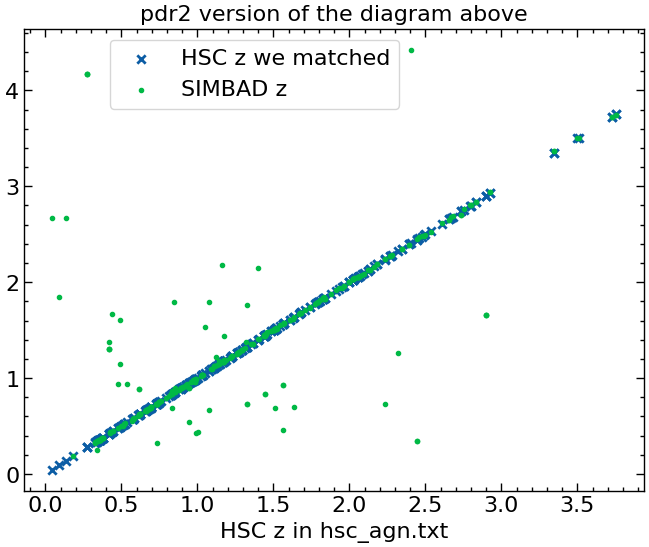

In [ ]:
data_hsc_mask = data_agn_updated['r_z'] == 1
data_coords = SkyCoord(data_agn_updated['RAdeg'], data_agn_updated['DEdeg'], unit=[u.deg, u.deg])

hsc_targets = ascii.read('spec/421976.csv', converters={key: [ascii.convert_numpy(bool)] for key in source_keys})
hsc_coords = SkyCoord(hsc_targets['specz_ra'], hsc_targets['specz_dec'], unit=[u.deg, u.deg])

idx_hsc_pdr2, idx_hsc_specz, d2d, _ = data_coords[data_hsc_mask].search_around_sky(hsc_coords, 0.5*u.arcsec)

compare_mask = data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z']!=0

plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][compare_mask], 
            hsc_targets[idx_hsc_pdr2]['specz_redshift'][compare_mask], 
            marker='x', label='HSC z we matched')
plt.scatter(data_agn_compare[data_hsc_mask][idx_hsc_specz]['HSC-z'][compare_mask], 
            data_agn_compare[data_hsc_mask][idx_hsc_specz]['SIMBAD-z'][compare_mask], 
            marker='.', label='SIMBAD z')

# # check if we actually have 3 different values
# x = data_agn_compare[data_hsc_mask]['HSC-z']
# y1 = hsc_targets[idx]['specz_redshift']
# y2 = data_agn_compare[data_hsc_mask]['SIMBAD-z']
# for i in range(len(data_agn_compare[data_hsc_mask])): 
#     if abs(x[i]-y1[i])>0.1 and abs(x[i]-y2[i])>0.1:
#         plt.plot([x[i], x[i]], [y1[i], y2[i]], color='k', linewidth=1)
# plt.plot(0, 0, color='k', linewidth=1, label='same target')

plt.xlabel('HSC z in hsc_agn.txt')
plt.ylabel('')
plt.title('pdr2 version of the diagram above')
plt.legend(frameon=True, loc='upper left',  bbox_to_anchor=(0.12, 1));

There are many targets fail to match in our inquiry, but there is no in consistency observed between DR2 and `hsc_agn.txt`. 

### Check those suspiciously aligned phot-z

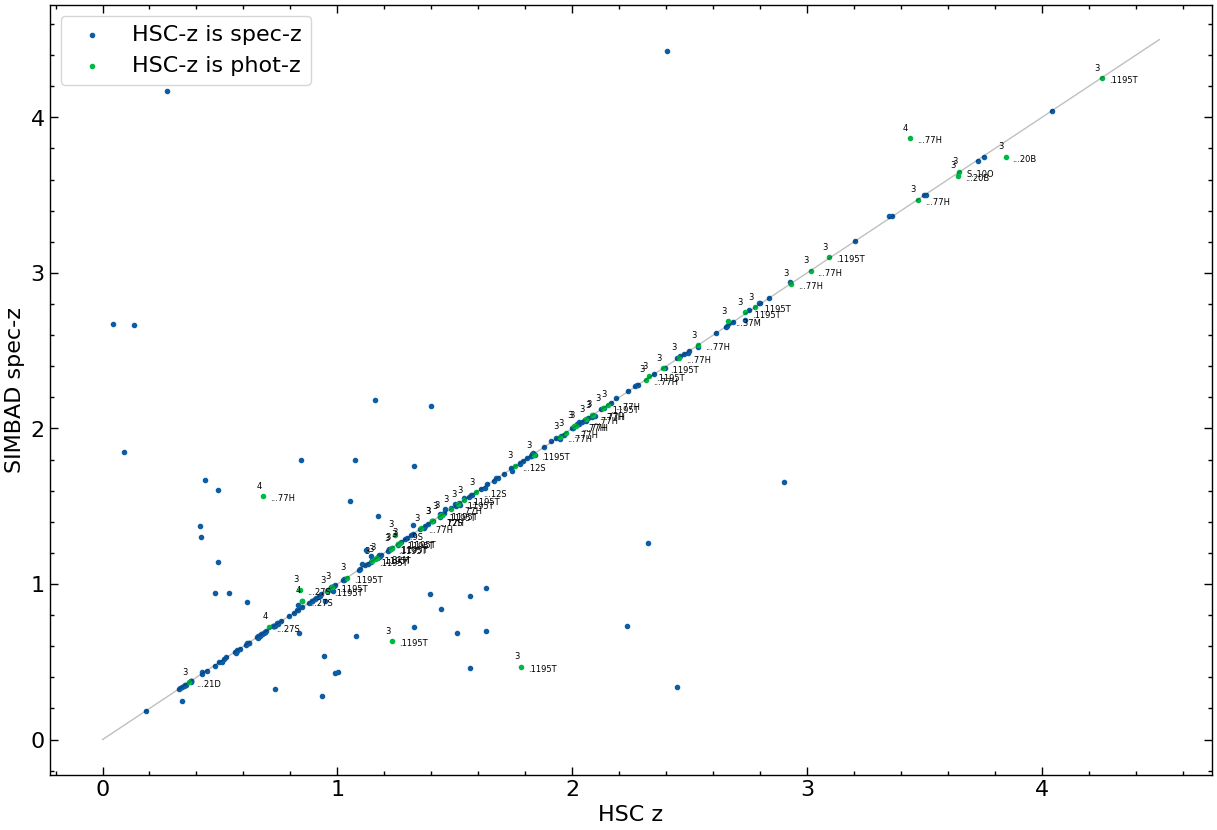

In [ ]:
plt.figure(figsize=[15, 10])

plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='spec'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='spec'], 
            marker='.', label='HSC-z is spec-z')
plt.scatter(data_agn_compare['HSC-z'][data_agn_compare['r_HSC-z']=='phot'], 
            data_agn_compare['SIMBAD-z'][data_agn_compare['r_HSC-z']=='phot'], 
            marker='.', label='HSC-z is phot-z')
# add bibcode to interested dots
for i, txt in enumerate(data_agn_compare['bib_SIMBAD-z']): #enumerate(np.arange(491)+1):
    if (data_agn_compare['r_HSC-z'][i]=='phot'): #(np.abs(data_agn_compare['HSC-z'][i] - data_agn_compare['SIMBAD-z'][i])>0.1) : 
        plt.annotate(txt[13:], (data_agn_compare['HSC-z'][i]+0.03, data_agn_compare['SIMBAD-z'][i]-0.03), size=6)
        plt.annotate(data_agn['r_z'][i], (data_agn_compare['HSC-z'][i]-0.03, data_agn_compare['SIMBAD-z'][i]+0.05), size=6)
plt.plot([0, 4.5], [0, 4.5], '-k', linewidth=1, alpha=0.25)
plt.xlabel('HSC z')
plt.ylabel('SIMBAD spec-z')
plt.legend(frameon=True)
plt.show()

Still, most data that has a `phot-z` label in HSC paper has a spec-z coming from zCOSMOS and DEIMOS.

In HSC paper, the `phot-z` comes form Chandra catalog (`2016ApJ...817...34M`) or COSMOS2015 catalog (`2016ApJS..224...24L`). 

For Chandra catalog, seems like 41% of its redsfhit is actually spec-z (chapter 6.1). 



## SDSS 

Download the spectra and label the table at once: 

In [33]:
idx_data = []
sdss_targets = []

for i in range(len(data_agn_updated)): 
    pos = data_coords[i]
    xid = SDSS.query_region(pos, radius='3 arcsec', spectro=True)
    if xid is None: 
        continue
    if len(xid)>=2: 
        print(i+1, 'has multiple spectra: ')
        xid.pprint_all()
    else: 
        print(i+1, 'has a spectrum')
    sdss_targets.append(xid)
    idx_data.append(i)

# manually clear output after inspection

/Users/colinburke/miniconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


2 has a spectrum
7 has a spectrum
8 has a spectrum
12 has a spectrum
24 has a spectrum
26 has a spectrum
28 has a spectrum
34 has a spectrum
36 has a spectrum
47 has a spectrum
64 has a spectrum
68 has a spectrum
73 has a spectrum
79 has a spectrum
85 has a spectrum
89 has a spectrum
91 has a spectrum
102 has a spectrum
109 has a spectrum
119 has a spectrum
120 has a spectrum
128 has a spectrum
132 has a spectrum
134 has a spectrum
136 has a spectrum
143 has a spectrum
147 has a spectrum
150 has a spectrum
151 has a spectrum
152 has a spectrum
155 has a spectrum
162 has a spectrum
170 has a spectrum
171 has a spectrum
174 has a spectrum
185 has a spectrum
190 has a spectrum
195 has a spectrum
203 has a spectrum
225 has a spectrum
231 has a spectrum
239 has a spectrum
242 has a spectrum
244 has a spectrum
249 has a spectrum
251 has a spectrum
261 has a spectrum
264 has a spectrum
266 has a spectrum
269 has a spectrum
280 has multiple spectra: 
       ra              dec               ob

fill in the table

In [34]:
data_agn_download['flag_sdss'] = False
data_agn_download['z_sdss'] = -1. 
for i in range(len(idx_data)): 
    data_agn_download['flag_sdss'][idx_data[i]] = True
    data_agn_download['z_sdss'][idx_data[i]] = sdss_targets[i]['z'][-1]

len(idx_data)

58

download the spectra

In [8]:
sdss_dir = 'spec/SDSS'
for i in range(len(idx_data)): 
    sp = SDSS.get_spectra(matches=sdss_targets[i])
    sp[-1].writeto(os.path.join(sdss_dir, 'sdss_'+str(data_agn_download[idx_data][i]['ID'])+'.fits'), overwrite=True) # if more than 1, then the last one (-1) is probably the newest

Notes: 
* ID=283 and 280 have 2 spectra at its coordinate but their data are very close 
* If we change radius to 3 arcsec we can get more result with no overlapping 

## Summary

In [64]:
data_agn_download.write('hsc_agn_download.txt', format='ascii', overwrite=True)

Check how many spectra each target has: 

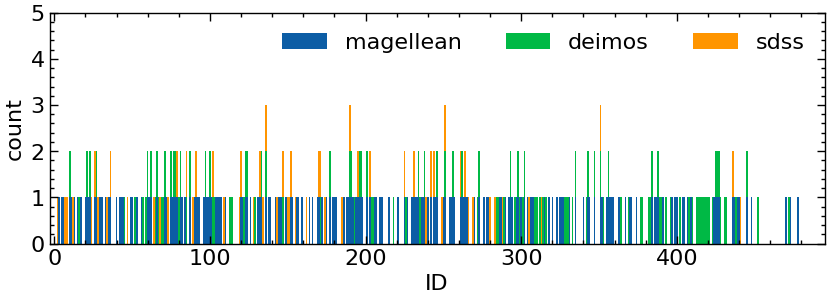

In [65]:
plt.figure(figsize=[10, 3])
spectra_counts = np.zeros(len(data_agn_download))
for flag in ['flag_magellean', 'flag_deimos', 'flag_sdss']: 
    plt.bar(data_agn_download['ID'], data_agn_download[flag], width=1, bottom=spectra_counts, label=flag[5:])
    spectra_counts += data_agn_download[flag]
plt.xlabel('ID')
plt.ylabel('count')
plt.legend(ncol=4)
plt.xlim(-3, 495)
plt.ylim(0, 5);

Visually check if most of the targets having more than 2 spectra is consistent

In [129]:
z_count = np.sum([data_agn_download[z]!=-1. for z in ['z_magellan', 'z_deimos', 'z_sdss']], axis=0)
data_agn_download[z_count==2]['ID', 'z_magellan', 'z_deimos', 'z_sdss'].pprint_all()
data_agn_download[z_count==3]['ID', 'z_magellan', 'z_deimos', 'z_sdss'].pprint_all()

 ID z_magellan z_deimos   z_sdss 
--- ---------- -------- ---------
 21     0.5545    0.555      -1.0
 23       0.83     0.83      -1.0
 26     0.8152     -1.0 0.8165812
 27     0.9736    1.634      -1.0
 36     2.1236     -1.0   2.12008
 60     2.1809    2.177      -1.0
 62     0.3356   0.3935      -1.0
 66     2.2699    2.283      -1.0
 71     1.6411    1.642      -1.0
 75     1.8281    1.836      -1.0
 77       3.35    3.328      -1.0
 78     1.5101    1.512      -1.0
 79     1.2586     -1.0  1.256511
 81      0.982    0.979      -1.0
 85       -1.0    2.025  2.020384
 87     1.3686    1.369      -1.0
 91     2.0313     -1.0  2.029814
 97     0.8535    0.851      -1.0
100     1.4436    1.444      -1.0
102       -1.0    1.434  1.435797
120     1.1563     -1.0  1.146491
123      0.969     0.97      -1.0
124     1.1645    1.171      -1.0
132     2.6145     -1.0  2.611786
133     1.8221     1.82      -1.0
147       -1.0    1.931  1.931359
152     2.6534     -1.0  2.652727
170     2.2767

inconsistent targets: 

In [192]:
hdu3 = fits.open('spec/DEIMOS/deimos_%d.fits'%ID)
hdu3[0].header

SIMPLE  =                    T /Dummy Created by MWRFITS v1.6a                  
BITPIX  =                    8 /Dummy primary header created by MWRFITS         
NAXIS   =                    0 /No data is associated with this header          
EXTEND  =                    T /Extensions may (will!) be present               

In [130]:
#hdu1[0].header

In [173]:
 data_agn_download['RAdeg'][data_agn_download['ID']==ID].data

array([150.00447])

sdss
sdss
sdss
sdss
sdss
sdss
sdss
sdss


<ipython-input-186-2200134957fe>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(10,4.5))


sdss
sdss
sdss
sdss
sdss
sdss


<ipython-input-186-2200134957fe>:70: RuntimeWarning: invalid value encountered in multiply
  ax.plot(np.logspace(start, stop, num)*(1+z_deimos), datatemp[1]/np.max(datatemp[1])*np.nanmax(flux_deimos),


ValueError: Axis limits cannot be NaN or Inf

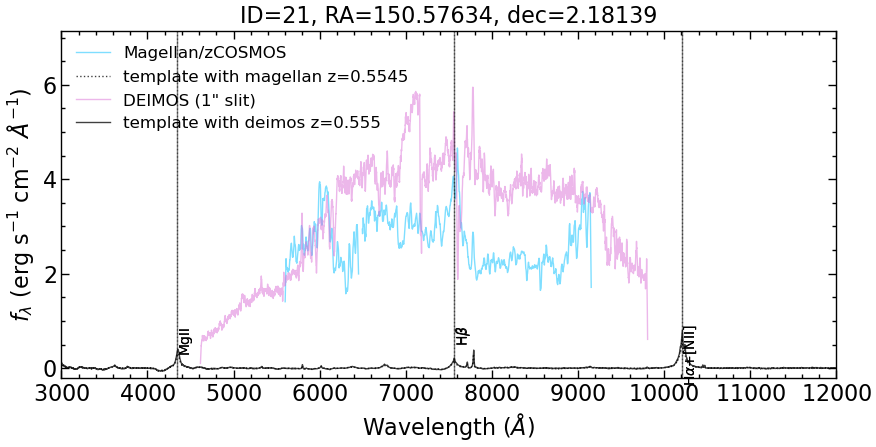

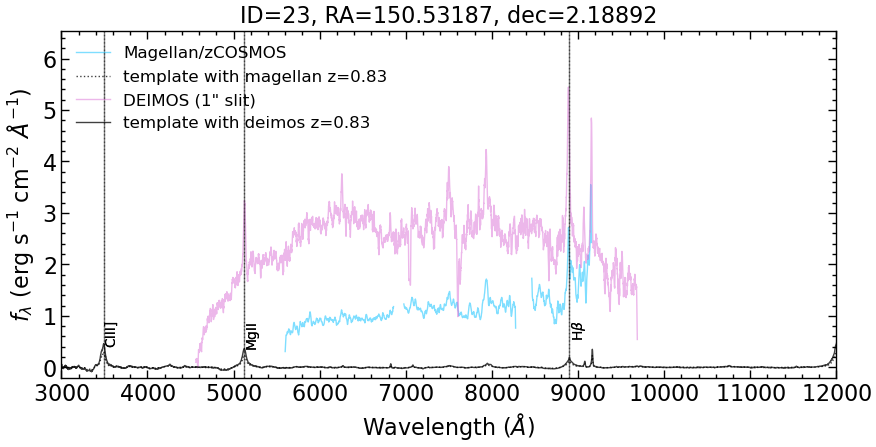

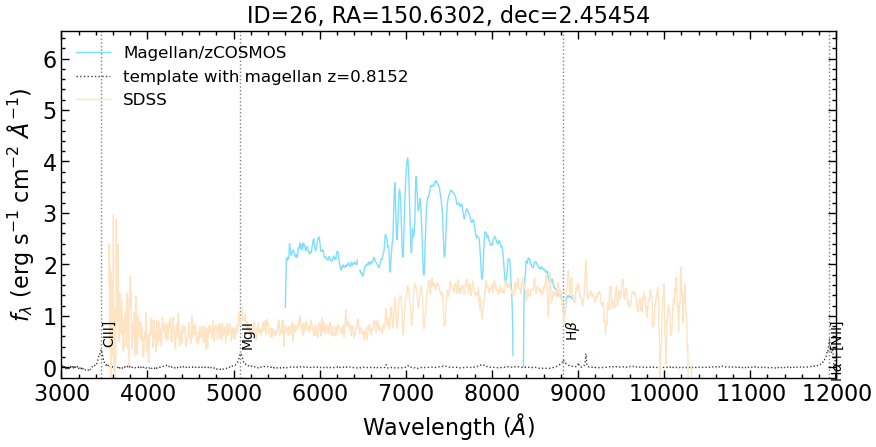

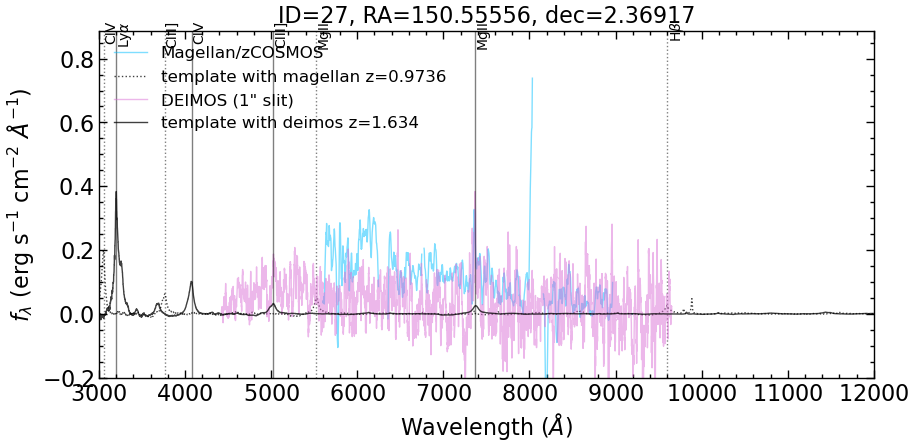

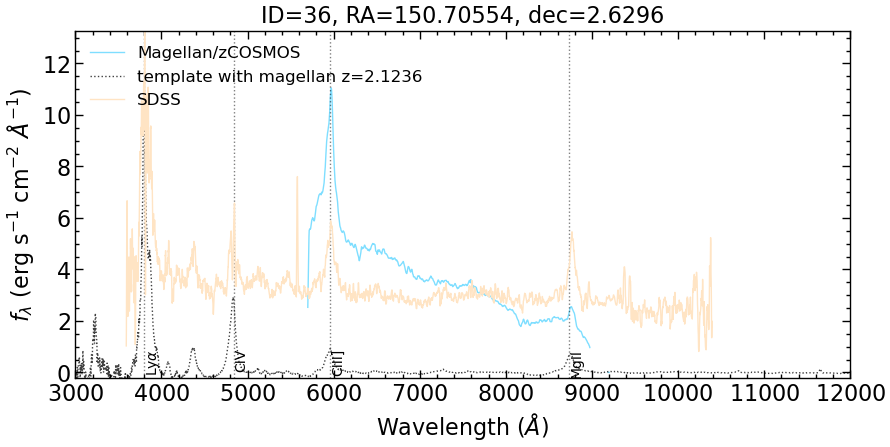

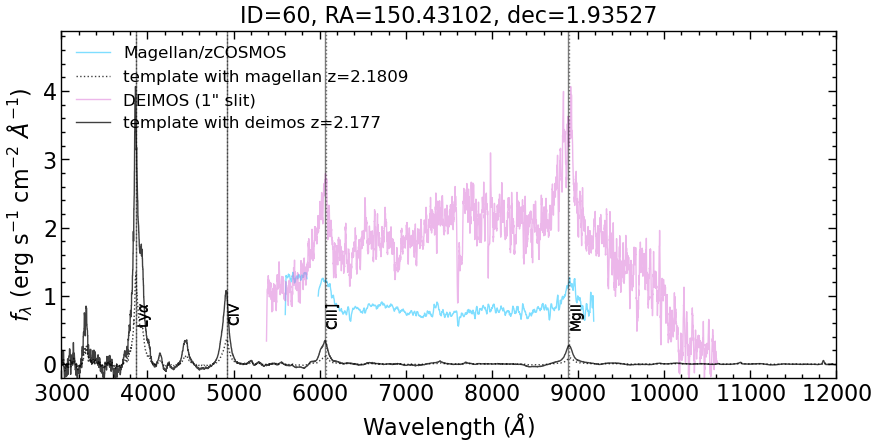

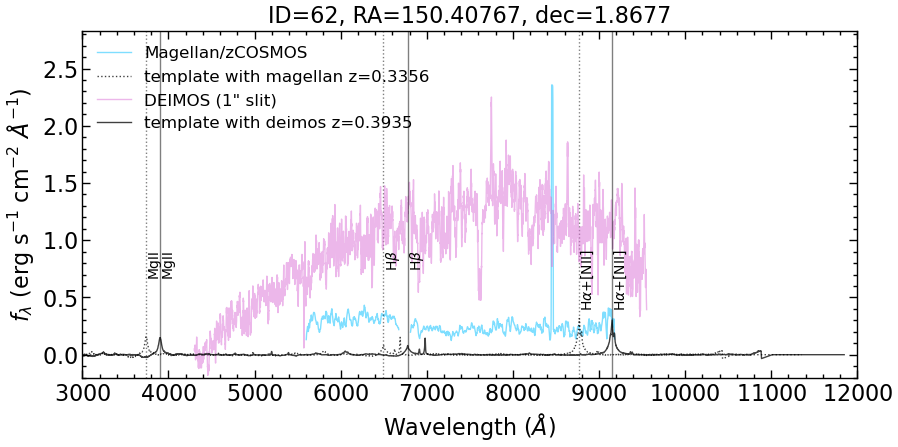

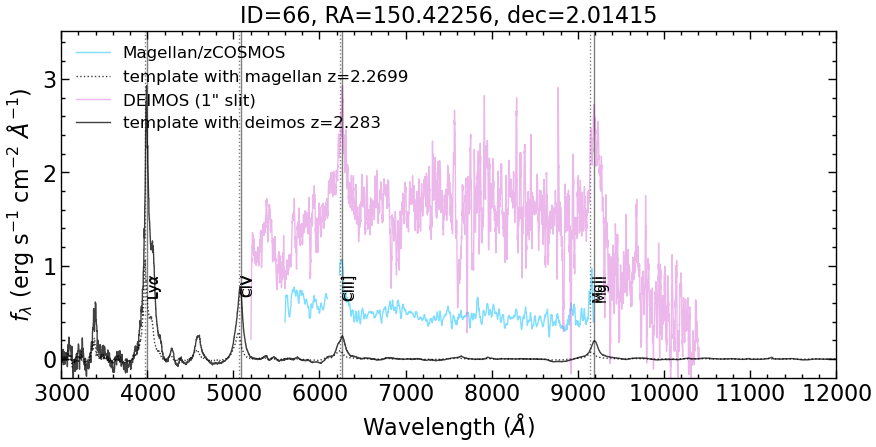

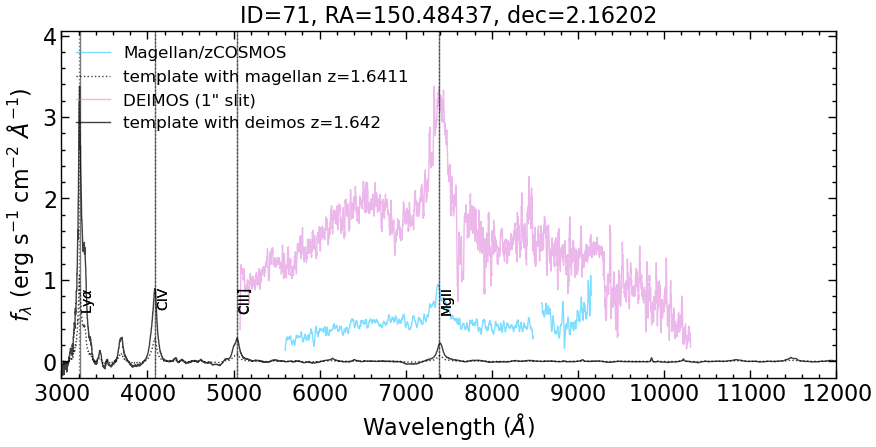

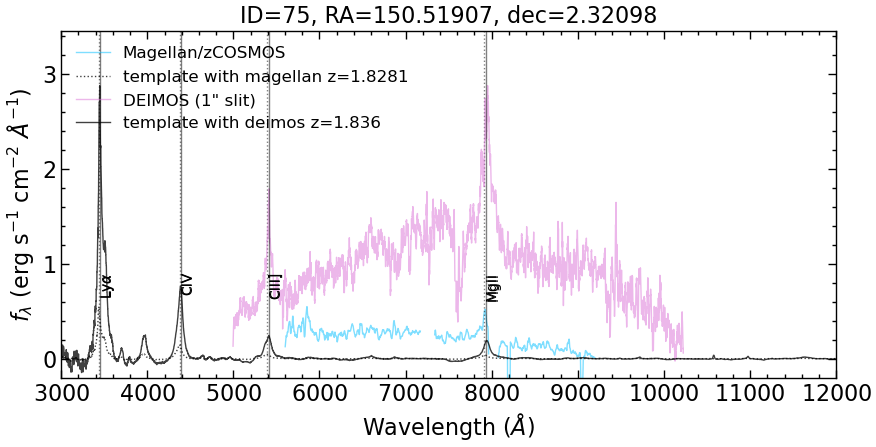

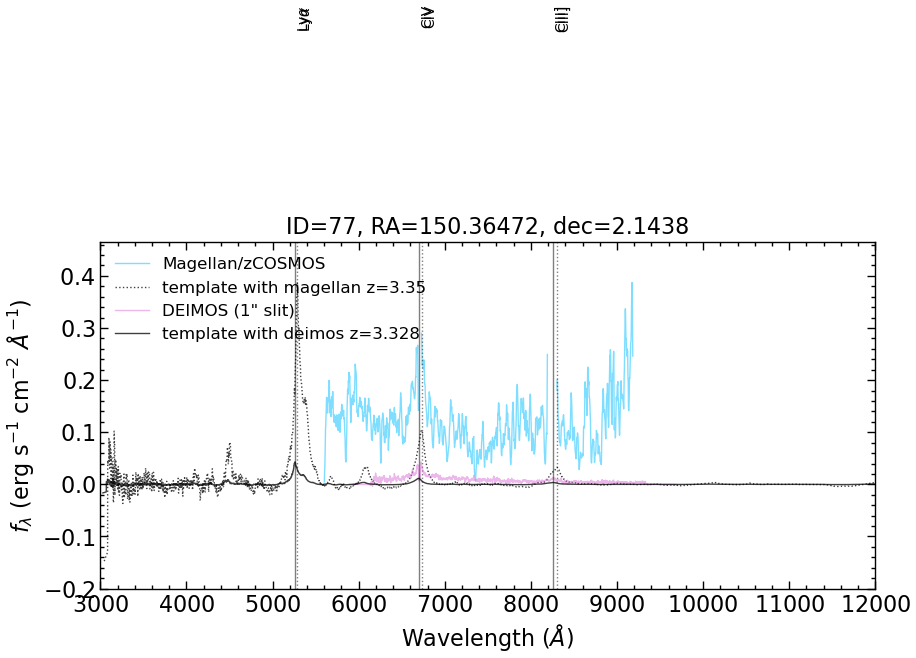

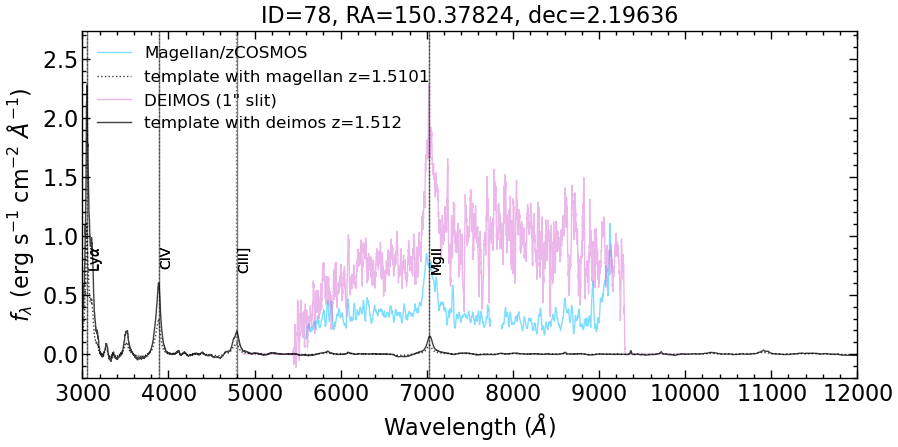

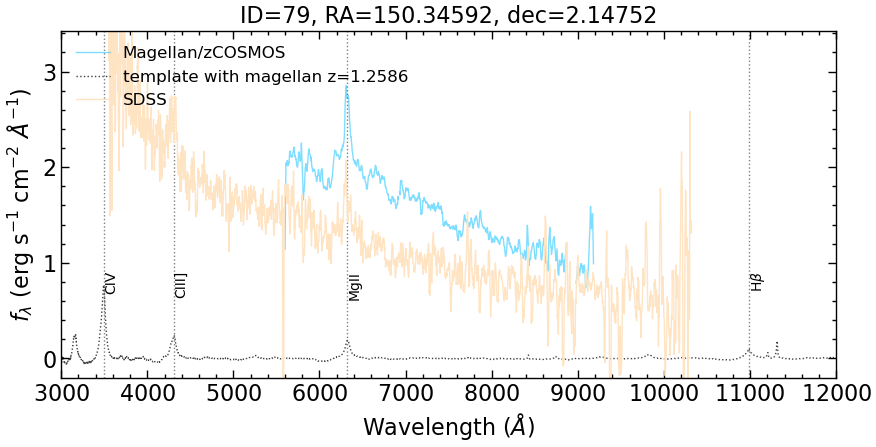

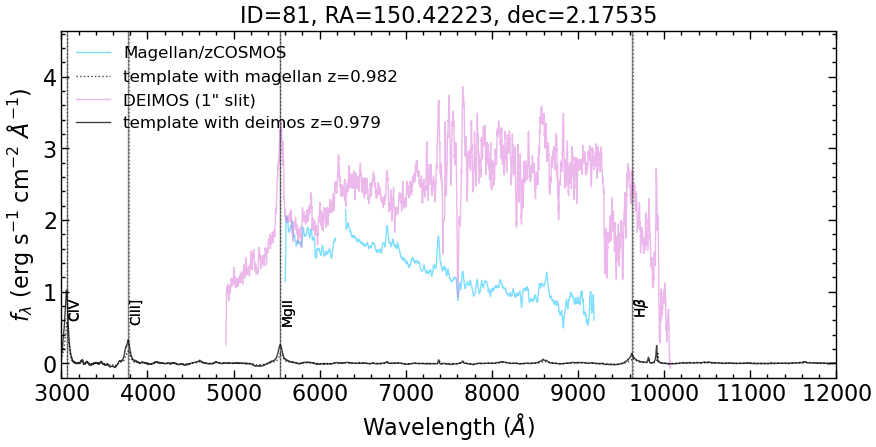

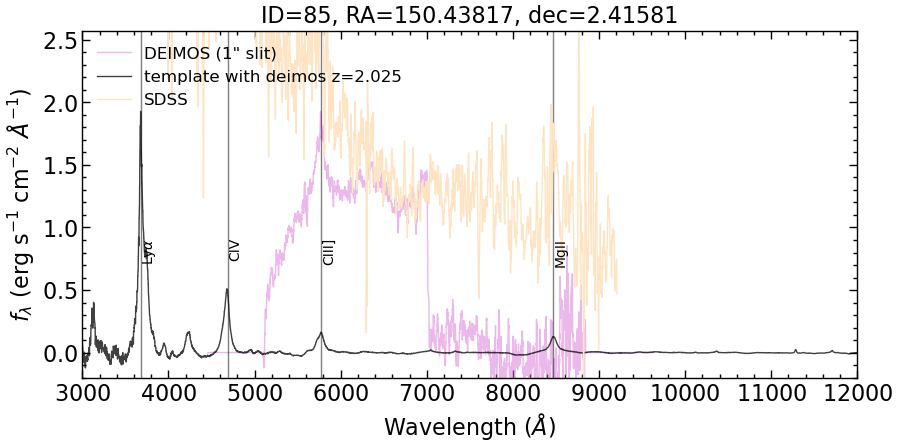

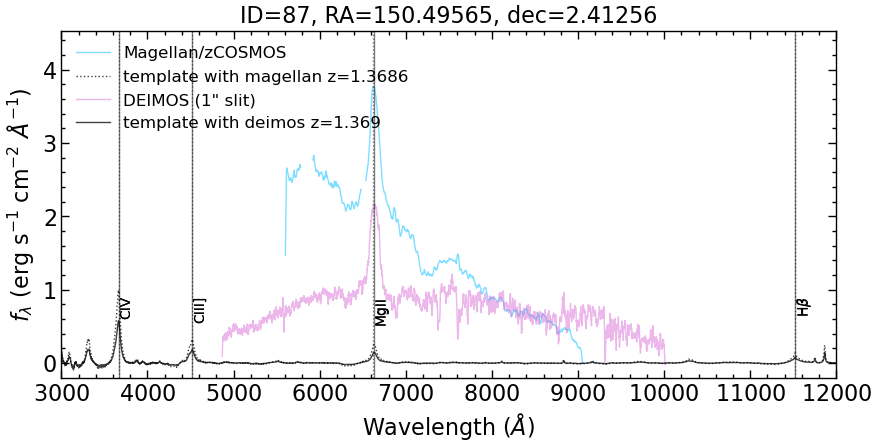

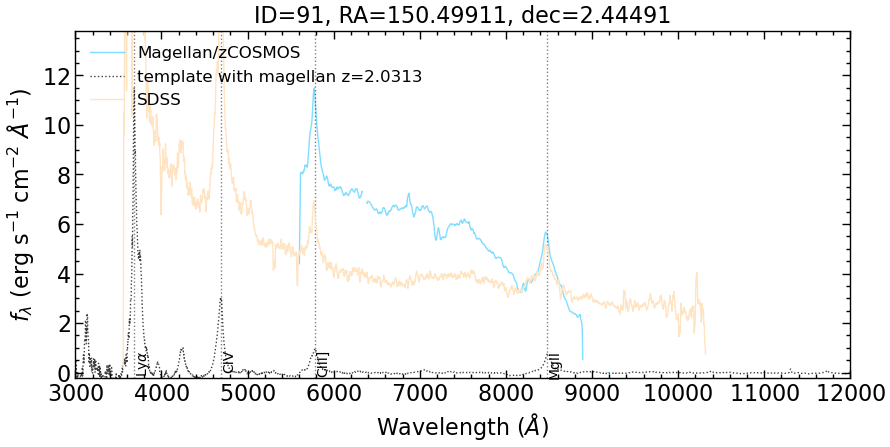

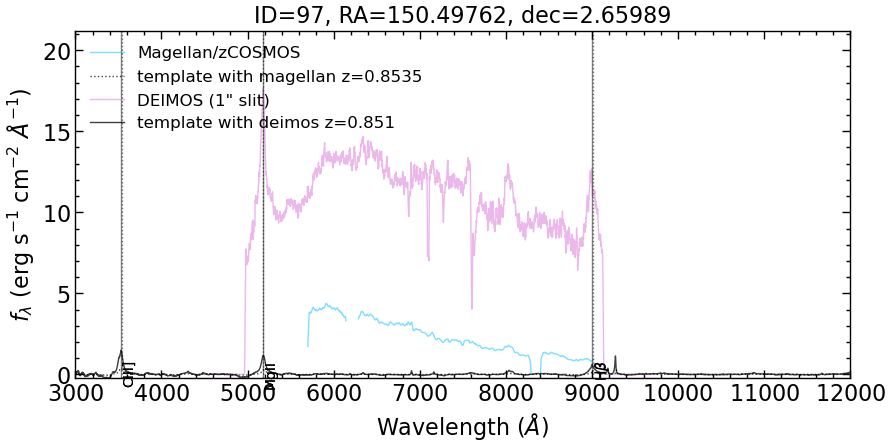

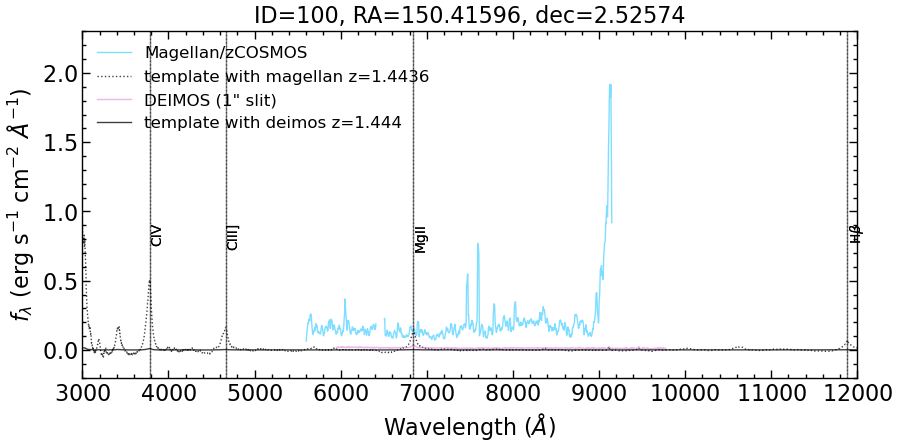

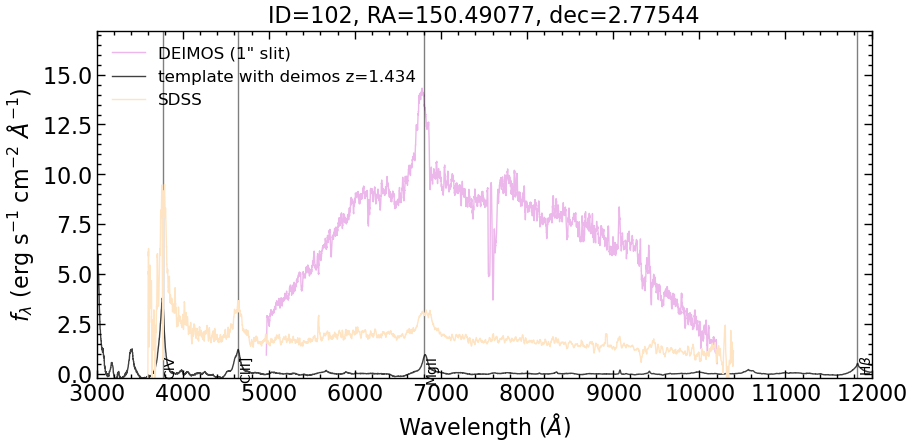

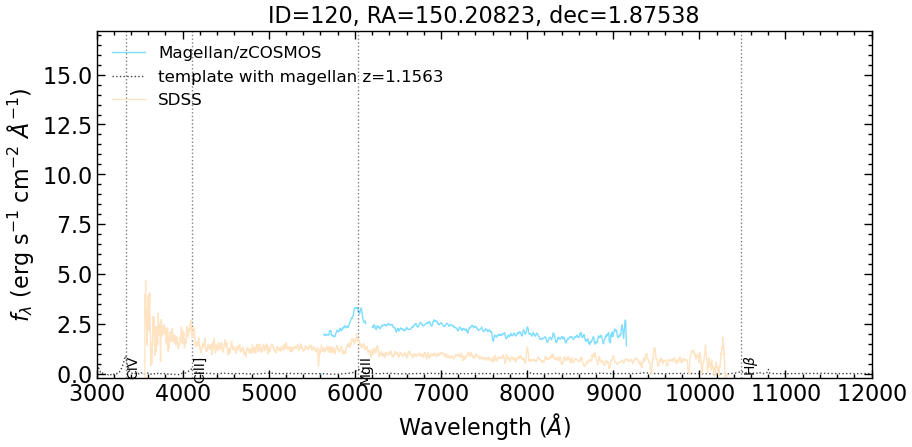

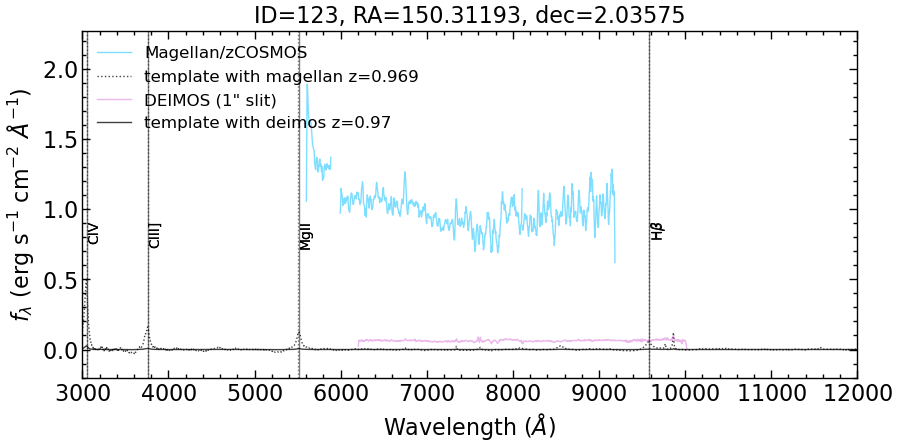

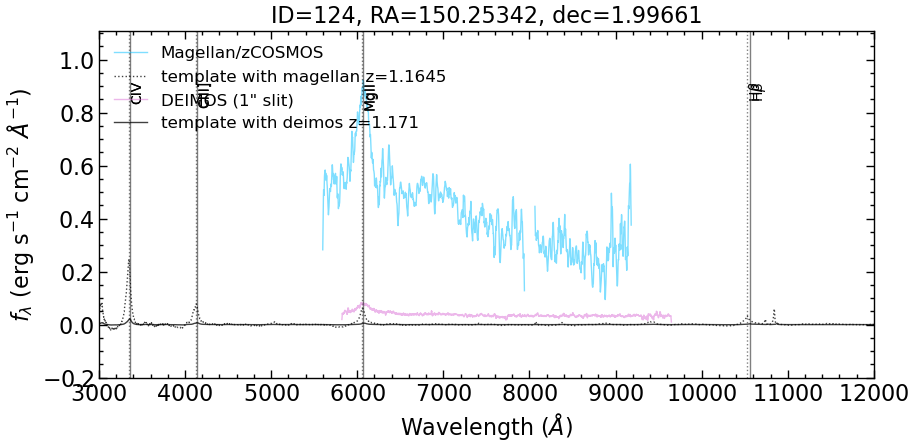

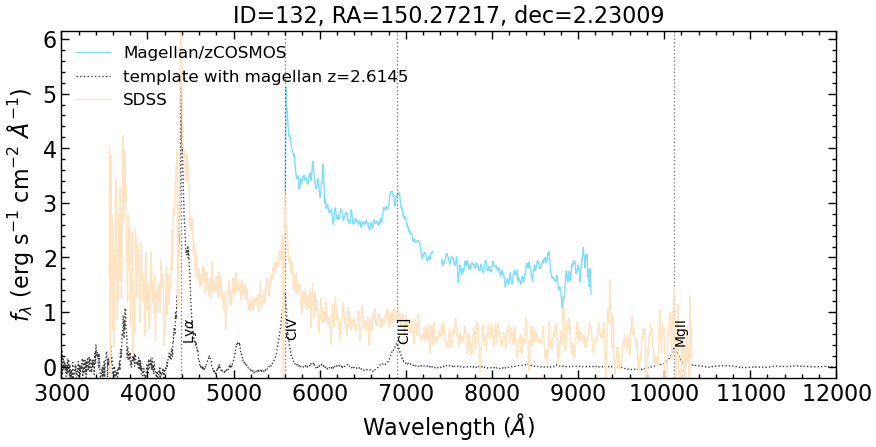

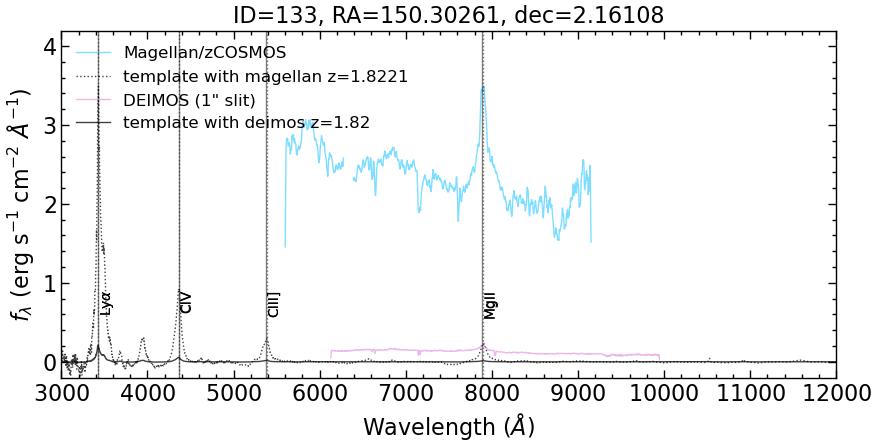

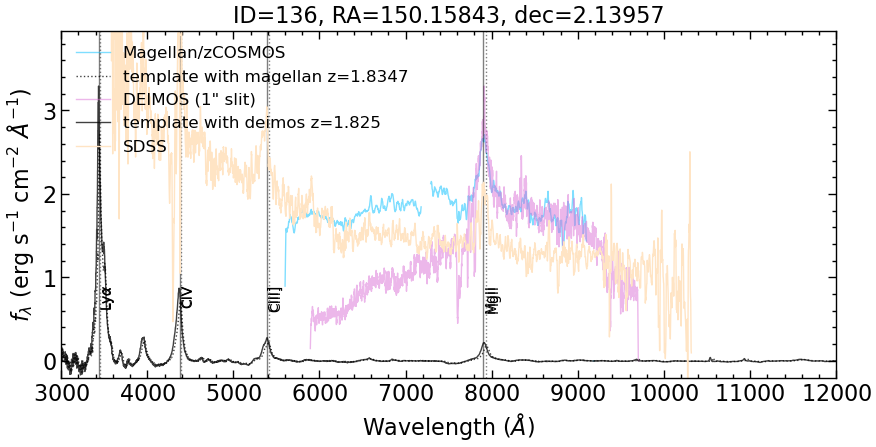

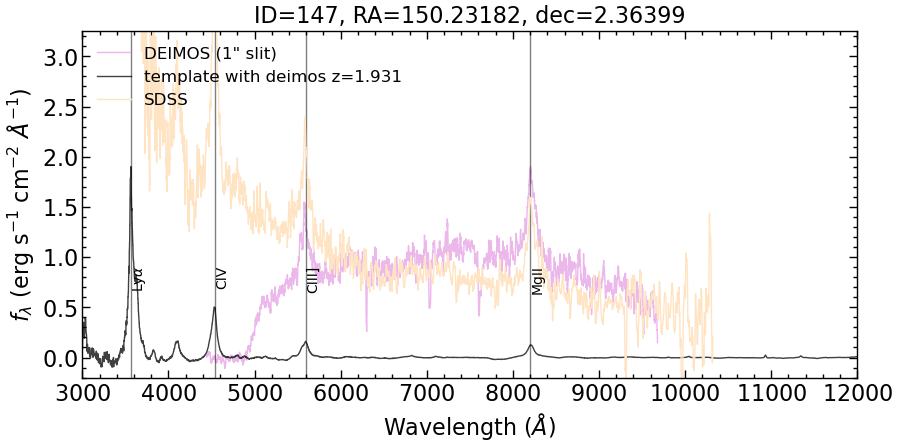

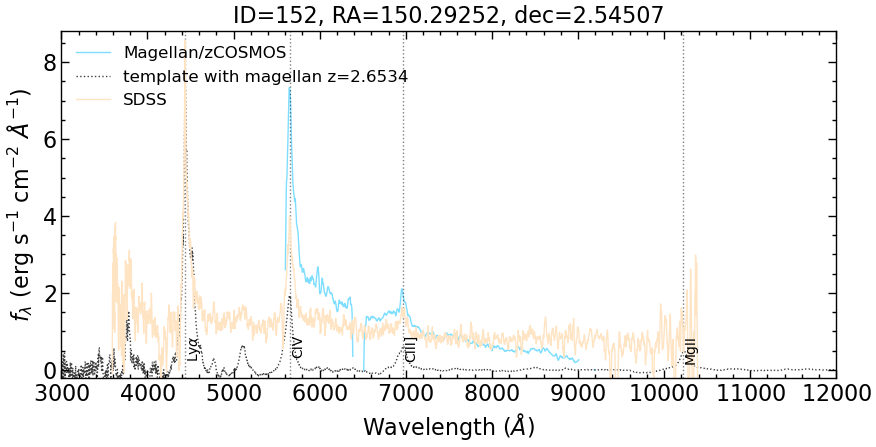

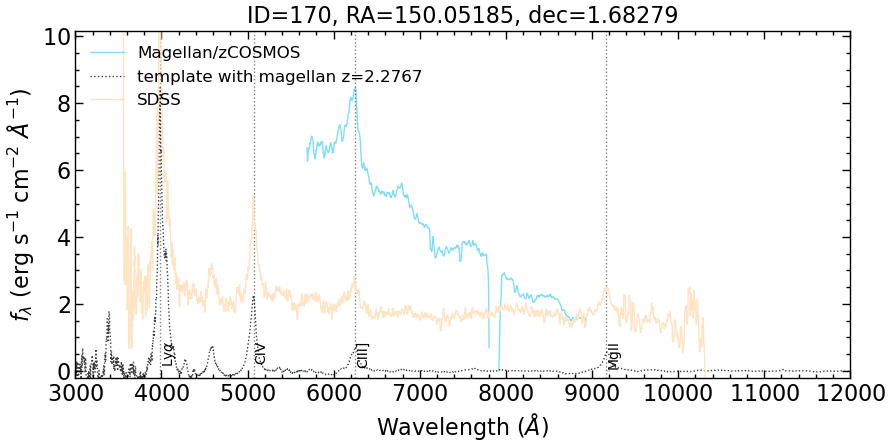

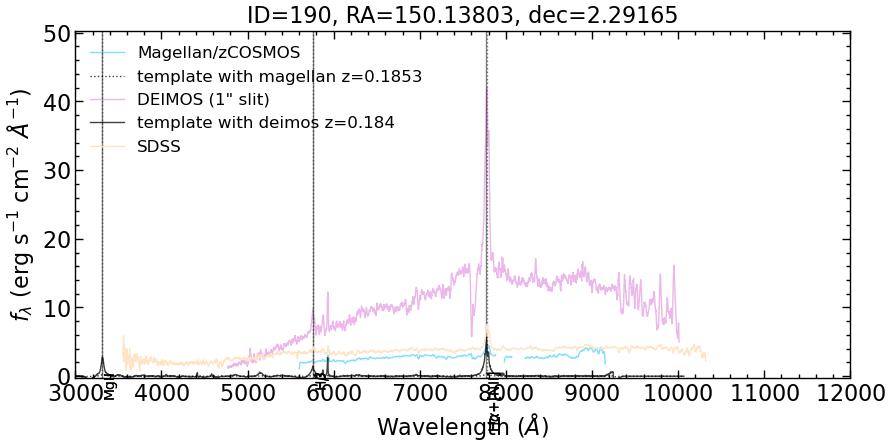

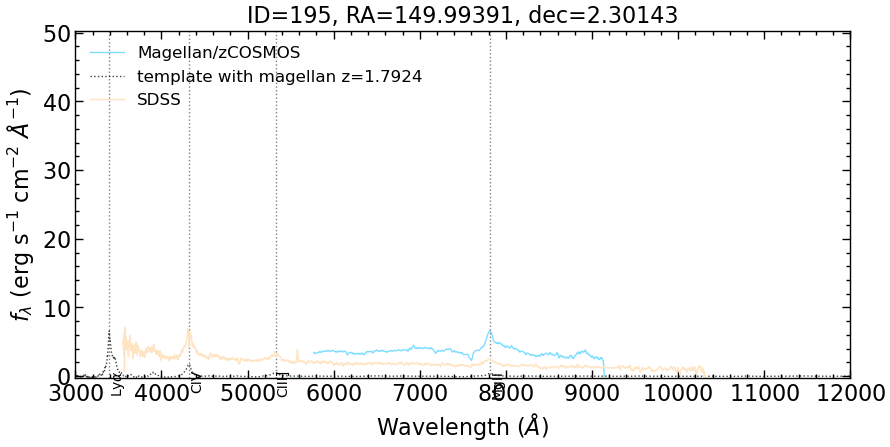

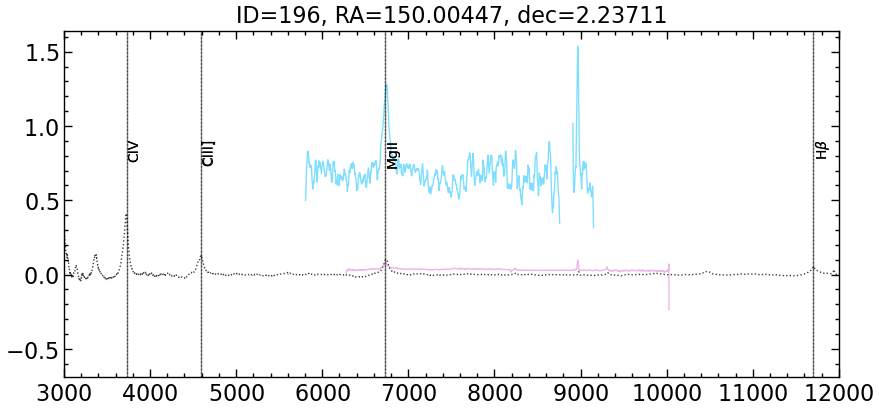

In [186]:
line_cen = np.array( [6564.60,            4862.68,    2797,    1908, 1549.06, 1215.67])
line_name = np.array([r'H$\alpha$+[NII]', r'H$\beta$','MgII'  , 'CIII]', 'CIV',   r'Ly$\alpha$'])

wmin = 3000
wmax = 12000

for ID in data_agn_download['ID'][z_count>1]: 
    
    ra = data_agn_download['RAdeg'][data_agn_download['ID']==ID].data[0]
    dec = data_agn_download['DEdeg'][data_agn_download['ID']==ID].data[0]

    fig, ax = plt.subplots(1,1, figsize=(10,4.5))
    
    # Line position
    axis_to_data = ax.transAxes + ax.transData.inverted()
    points_data = axis_to_data.transform((0, 0.92))
    
    # Template data
    hdutemp = SDSS.get_spectral_template('qso')[0]
    datatemp = hdutemp[0].data
    headertemp = hdutemp[0].header
    start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
    

    # Magellan
    if os.path.isfile('spec/Magellan/magellean_%d.fits'%ID): 
        hdu1 = fits.open('spec/Magellan/magellean_%d.fits'%ID)
        #print(hdu1[0].header)
        data1 = hdu1[0].data
        # mask
        data1_mask = np.full(data1[1].shape, np.nan)
        data1_mask[data1[3]>0] = data1[1][data1[3]>0]
        flux_magellean = convolve(data1_mask/1e-17, Box1DKernel(width=10))
        flux_err_magellean = convolve(data1[2], Box1DKernel(width=10))
        med_magellean = np.median(flux_magellean)
        #plt.plot(data1[0], flux_magellean/med_magellean, label='Magellan smoothed', linewidth=1, alpha=0.5)
        ax.plot(data1[0], flux_magellean, label='Magellan/zCOSMOS',
                 color='deepskyblue', linewidth=1, alpha=0.5)
        #plt.fill_between(data1[0], flux_magellean-flux_err_magellean, flux_magellean+flux_err_magellean,
        #                 color='skyblue', linewidth=0, alpha=0.1)
        
        # Template
        z_magellean = data_agn_download['z_magellan'][ID-1]
        ax.plot(np.logspace(start, stop, num)*(1+z_magellean), datatemp[1]/np.max(datatemp[1])*np.nanmax(flux_magellean), 
                 label='template with magellan z='+str(z_magellean), linewidth=1, alpha=0.75, color='k', linestyle=':')
    
        for ll in range(len(line_cen)):
            if line_cen[ll]*(1+z_magellean) > wmin and line_cen[ll]*(1+z_magellean) < wmax:
                ax.axvline(line_cen[ll]*(1+z_magellean), 0, 5, linewidth=1, color='k', linestyle=':', alpha=0.5)
                ax.text(line_cen[ll]*(1+z_magellean) + 7, points_data[1], line_name[ll], rotation=90, fontsize=10, va='top')


    # DEIMOS
    if os.path.isfile('spec/DEIMOS/deimos_%d.fits'%ID): 
        hdu3 = fits.open('spec/DEIMOS/deimos_%d.fits'%ID)
        #print(hdu3[0].header)
        data3 = hdu3[1].data
        flux_deimos = convolve(data3['FLUX'][0]*1e-19/1e-17, Box1DKernel(width=20))
        #flux_err_deimos = convolve(1/np.sqrt(data3['IVAR'][0])*1e-19/1e-17, Box1DKernel(width=50))
        # No error providede, assume ~10%
        flux_err_deimos = 0.1*flux_deimos
        med_deimos = np.median(flux_deimos)
        ax.plot(data3['LAMBDA'][0], flux_deimos, label='DEIMOS (1" slit)',
                 color='orchid', linewidth=1, alpha=0.5)
        #plt.fill_between(data3['LAMBDA'][0], flux_deimos-flux_err_deimos, flux_deimos+flux_err_deimos,
        #                 color='forestgreen', linewidth=0, alpha=0.1)
        
        # Template
        z_deimos = data_agn_download['z_deimos'][ID-1]
        ax.plot(np.logspace(start, stop, num)*(1+z_deimos), datatemp[1]/np.max(datatemp[1])*np.nanmax(flux_deimos), 
                 label='template with deimos z='+str(z_deimos), linewidth=1, alpha=0.75, color='k', linestyle='-')

        for ll in range(len(line_cen)):
            if line_cen[ll]*(1+z_deimos) > wmin and line_cen[ll]*(1+z_deimos) < wmax:
                ax.axvline(line_cen[ll]*(1+z_deimos), 0, 5, linewidth=1, color='k', alpha=0.5)
                ax.text(line_cen[ll]*(1+z_deimos) + 7, points_data[1], line_name[ll], rotation=90, fontsize=10, va='top')

                
    # SDSS
    if os.path.isfile('spec/SDSS/sdss_%d.fits'%ID): 
        hdu = fits.open('spec/SDSS/sdss_%d.fits'%ID)
        flux_sdss = convolve(hdu[1].data['flux'], Box1DKernel(width=10))
        ax.plot(10**hdu[1].data['loglam'], flux_sdss,
                 label='SDSS', color='bisque', linewidth=1);

                
        
    ax.set_title(f'ID={ID}, RA={ra}, dec={dec}')
    ax.set_xlim(wmin, wmax)
    ax.set_ylim(-0.2, 1.2*np.nanmax(np.append(flux_deimos, flux_magellean)))
    ax.legend(fontsize=12, loc=2);
    
    ax.set_ylabel(r'$f_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1})$')
    ax.set_xlabel(r'Wavelength ($\AA$)')
    

One consistent target: 

1.8347


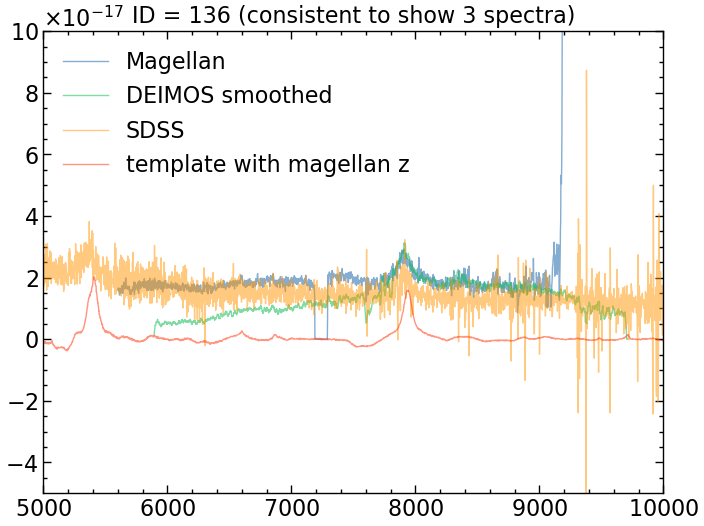

In [96]:
# ID = 136

# Magellean
hdu1 = fits.open('spec/Magellan/magellean_136.fits')
data1 = hdu1[0].data
plt.plot(data1[0], data1[1], label='Magellan', linewidth=1, alpha=0.5)

# DEIMOS
hdu3 = fits.open('spec/DEIMOS/deimos_136.fits')
data3 = hdu3[1].data
box1d_kernel = Box1DKernel(width=30)
flux = convolve(data3['FLUX'][0]*1e-19, box1d_kernel)
plt.plot(data3['LAMBDA'][0], flux, label='DEIMOS smoothed', linewidth=1, alpha=0.5)
# plt.plot(data3['LAMBDA'][0], data3['FLUX'][0]*1e-18, label='DEIMOS', linewidth=0.1)

# SDSS
hdu = fits.open('spec/SDSS/sdss_136.fits')
plt.plot(10**hdu[1].data['loglam'], hdu[1].data['flux']*1e-17, label='SDSS', linewidth=1, alpha=0.5);

# template
hdutemp = SDSS.get_spectral_template('qso')[0]
datatemp = hdutemp[0].data
headertemp = hdutemp[0].header
start, stop, num = headertemp['COEFF0'], headertemp['COEFF0']+headertemp['COEFF1']*datatemp[1].size, datatemp[1].size
z_magellean = data_agn_download['z_magellan'][135]
print(z_magellean)
plt.plot(np.logspace(start, stop, num)*(1+z_magellean), datatemp[1]*1e-17, label='template with magellan z', linewidth=1, alpha=0.5)

plt.title('ID = 136 (consistent to show 3 spectra)')
plt.xlim(5000, 10000)
plt.ylim(-0.5e-16, 1e-16)
plt.legend();